### Import the required libraries

In [66]:
import os, warnings
os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"
warnings.filterwarnings("ignore", category=FutureWarning, module=r"sklearn(\..*)?$")
warnings.filterwarnings("ignore", message=r".*_validate_data.*")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle

### Load Weather in Australia Dataset

In [2]:
df = pd.read_csv('weatherAUS.csv')

In [3]:
# view first 5 rows of the dataframe
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### Dataset Overview

In [4]:
# print the shape of the dataset (i.e. no of rows and columns)
print(df.shape)

# get the column names and their data types
print(df.info())

# check for null values for each column
print(df.isnull().sum().sort_values(ascending=False))

(145460, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       8

In [5]:
# statistical measures of the data
print(df.describe())

             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.0000

#### Dataset Summary and Outlier Analysis

The dataset contains **22 features (independent variables)** and **145,460 entries**, with a mix of numerical and categorical data types. Almost all features—including the target variable—contain missing values, ranging from **0.9% up to 48%**. These missing entries will be addressed through appropriate imputation techniques or dropped prior to modeling.

From the statistical analysis, several important observations were made:

- **Outliers**:
    - Features such as ```Rainfall```, ```Evaporation```, ```MinTemp```, ```MaxTemp```, ```Temp9am```, and ```Temp3pm``` show rare but plausible anomalies (e.g., heatwaves, extreme rainfalls or extreme winter cold). These will be retained, as they may represent legitimate weather extremes rather than errors.

- **Invalid Values**:
    - ```Humidity9am``` and ```Humidity3pm``` include minimum values of 0%, which are not theoretically possible. These entries will be filtered out from the dataset.

- **Feature Selection**:
    - Based on domain expertise, ```WindGustDir```, ```WindDir9am```, and ```WindDir3pm``` are expected to have limited predictive value and will be excluded from our dataset.
    - The ```Location``` feature will also be dropped, as the dataset already includes direct weather parameter. This action would remove unnecessary redundancies.
    - The ```Date``` feature will be transformed to extract the year.

In [6]:
# filter out 0% humidity values from the Humidity9am and Humidity3pm features
df = df[(df['Humidity9am'] != 0) & (df['Humidity3pm'] != 0)]

In [7]:
# extract year from Date
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

In [8]:
# drop Location, WindGustDire, WindDir9am, WindDir3pm and Date features from the dataset
df = df.drop(columns=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

In [9]:
# drop null values in RainToday and RainTomorrow features
df = df.dropna(subset=['RainToday', 'RainTomorrow'], axis=0)

In [10]:
# confirm above actions have been completed by printing the shape of the dataframe
print(df.shape)

(140783, 19)


### Perform Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of RainTomorrow')

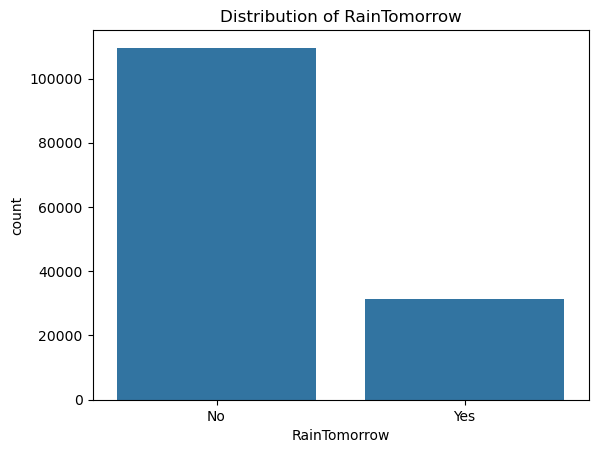

In [11]:
# plot the target variable to understand the distribution
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribution of RainTomorrow')

From the figure above, we can see that there is a clear **class imbalance** in the target variable. This needs to be taken into account when selecting our algorithms. Algorithms such as k-Nearest Neighbors are very sensitive to class imbalance and may not perform well on classification metrics such as precision or recall.

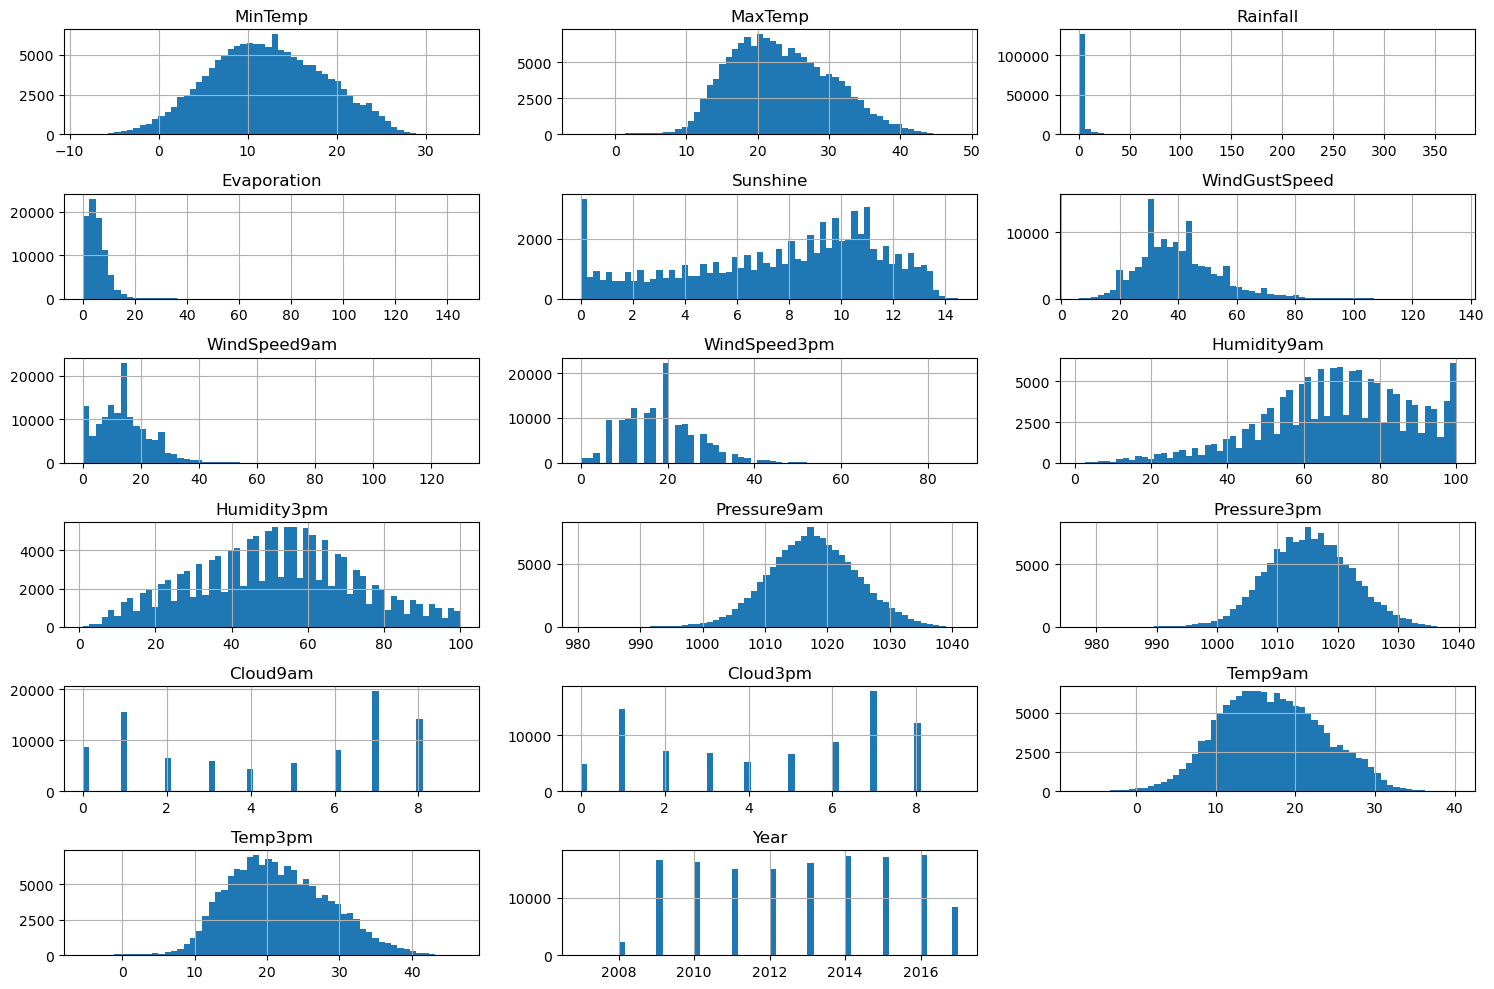

In [12]:
# plot the distribution of all features
df.drop('RainTomorrow', axis=1).hist(bins=60, figsize=(15,10), layout=(6,3))
plt.tight_layout()

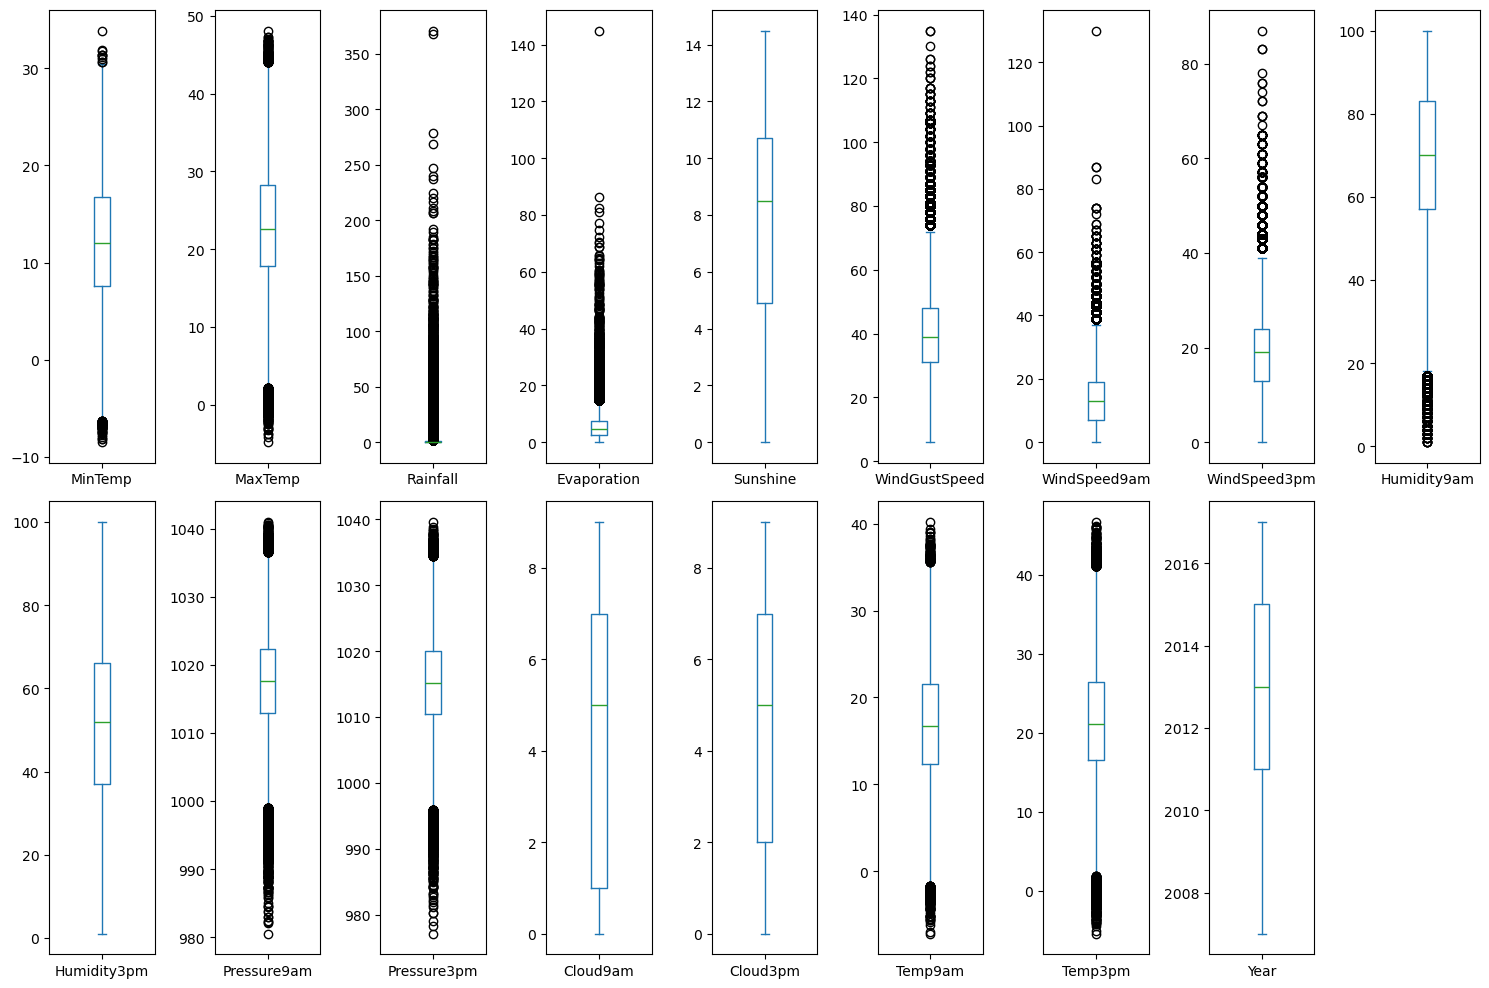

In [13]:
# plot the box plot diagrams for each feature
df.drop('RainTomorrow', axis=1).plot(kind='box', subplots=True, layout=(2,9), figsize=(15,10))
plt.tight_layout()

From the plots above, we observe that most features roughly follow a normal distribution. For this reason, we will focus on models that are less sensitive to distributional assumptions, such as Random Forest or Decision Trees. We can see from the box plot diagrams that most features contain potential outliers. **However, many of these values may represent valid extreme weather events (e.g., heatwaves, extreme rainfalls or unusual cold days) rather than errors**. Our assumptions are that features such as Pressure, Cloud, and Humidity have a direct relationship to our target variable. These assumptions will be shown below in form of graphs.

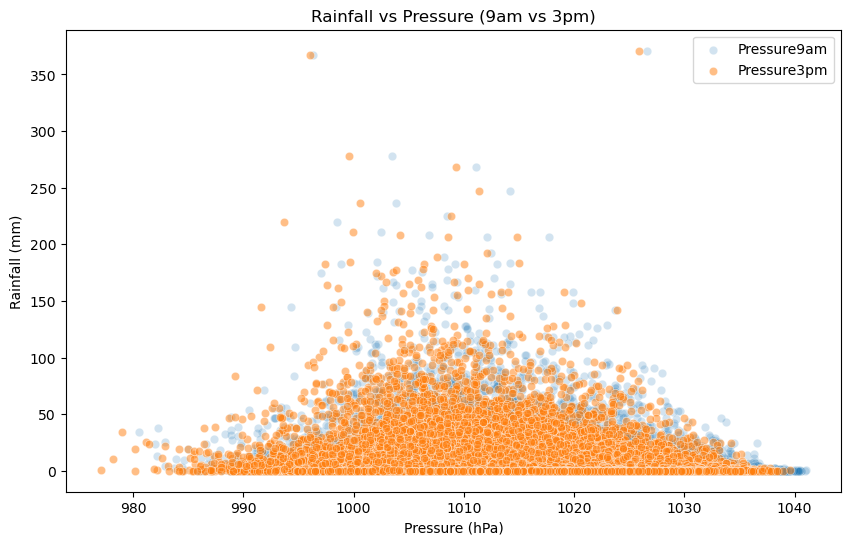

In [14]:
# plot Rainfall vs. Pressure diagrams
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="Pressure9am", y="Rainfall", label="Pressure9am", alpha=0.2)
sns.scatterplot(data=df, x="Pressure3pm", y="Rainfall", label="Pressure3pm", alpha=0.5)
plt.title("Rainfall vs Pressure (9am vs 3pm)")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Rainfall (mm)")
plt.legend()

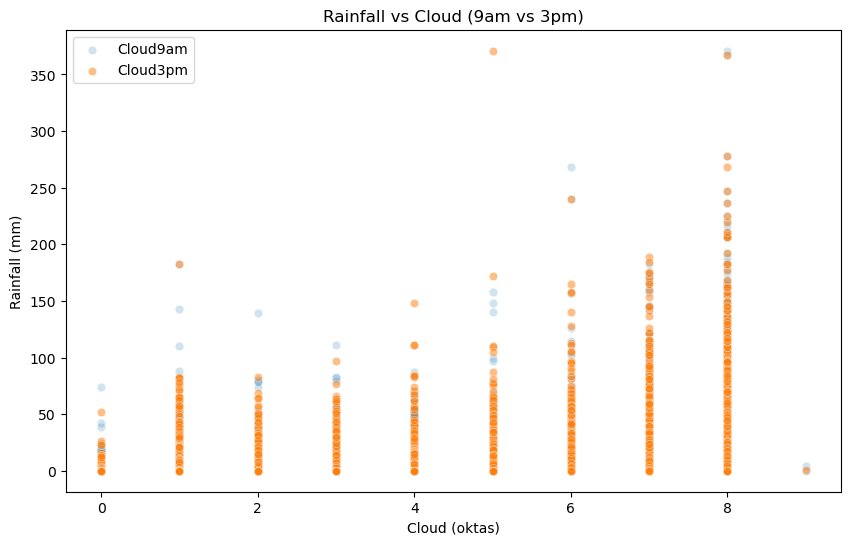

In [15]:
# plot Rainfall vs. Cloud diagrams
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="Cloud9am", y="Rainfall", label="Cloud9am", alpha=0.2)
sns.scatterplot(data=df, x="Cloud3pm", y="Rainfall", label="Cloud3pm", alpha=0.5)
plt.title("Rainfall vs Cloud (9am vs 3pm)")
plt.xlabel("Cloud (oktas)")
plt.ylabel("Rainfall (mm)")
plt.legend()

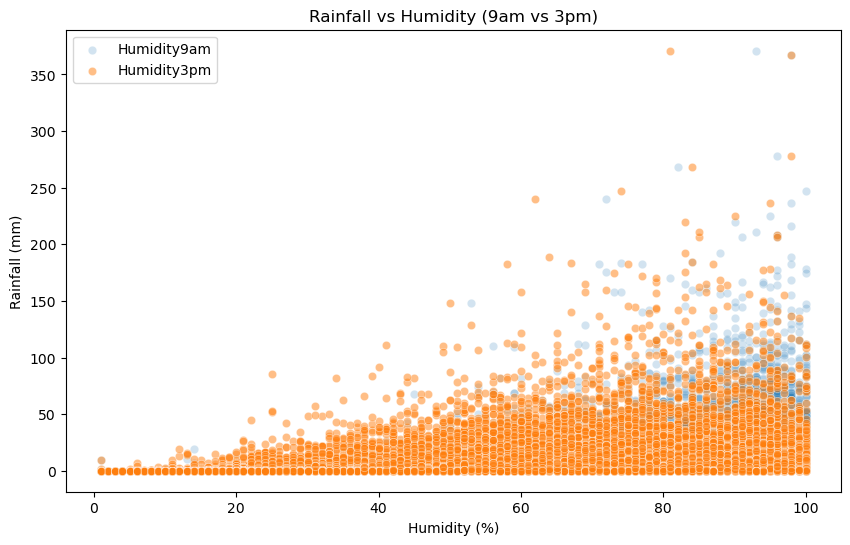

In [16]:
# plot Rainfall vs. Cloud diagrams
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="Humidity9am", y="Rainfall", label="Humidity9am", alpha=0.2)
sns.scatterplot(data=df, x="Humidity3pm", y="Rainfall", label="Humidity3pm", alpha=0.5)
plt.title("Rainfall vs Humidity (9am vs 3pm)")
plt.xlabel("Humidity (%)")
plt.ylabel("Rainfall (mm)")
plt.legend()

The three plots above indicate positive relationships between rainfall and humidity, pressure, and cloud cover. These weather features interact with one another, and their combined influence increases the likelihood of rain (target variable = 1).

### Data Preparation and Pipeline Setup

In [17]:
# review the count for each year
df['Year'].value_counts().sort_index(ascending=True)

Year
2007       61
2008     2229
2009    16514
2010    16191
2011    14983
2012    14894
2013    15934
2014    17180
2015    17087
2016    17341
2017     8369
Name: count, dtype: int64

<Axes: xlabel='Year', ylabel='count'>

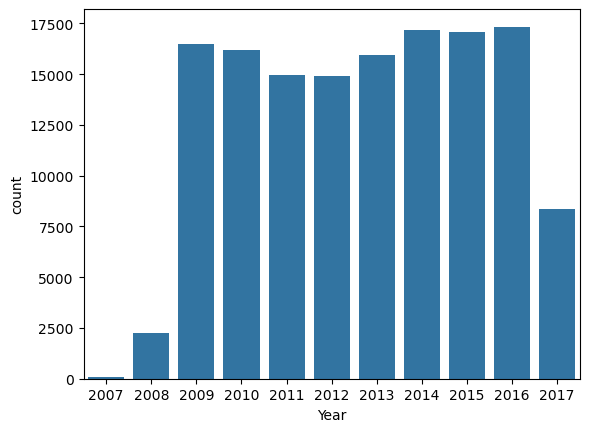

In [18]:
sns.countplot(x='Year', data=df)

In [19]:
# manually split the dataset by year for training and testing since the data is in chronological order
X1 = df[df['Year'] < 2015]
X2 = df[df['Year'] >= 2015]

print('Train Set (X1):', X1.shape)
print(f'Test Set (X2):', X2.shape)

# calculate the % split for each
train_split = len(X1)/len(df)
test_split = 1 - train_split

print(f'\n% Train Split: {train_split*100:.1f}%')
print(f'% Test Split: {test_split*100:.1f}%')

Train Set (X1): (97986, 19)
Test Set (X2): (42797, 19)

% Train Split: 69.6%
% Test Split: 30.4%


In [20]:
# assign X and y variables to our split
X_train = X1.drop(columns=['RainTomorrow', 'Year'])
y_train = X1['RainTomorrow']

X_test = X2.drop(columns=['RainTomorrow', 'Year'])
y_test = X2['RainTomorrow']

In [21]:
# convert target variable to numerical values
y_train = y_train.map({'No': 0, 'Yes': 1})
y_test  = y_test.map({'No': 0, 'Yes': 1})

In [22]:
# build pipeline
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

num_pipe = Pipeline([('impute', SimpleImputer(strategy='median')),
                     ('scaler', RobustScaler())])

cat_pipe = Pipeline([('encoder', OneHotEncoder(handle_unknown='error'))])

preprocessor = ColumnTransformer([('num', num_pipe, num_cols),
                                  ('cat', cat_pipe, cat_cols)])

### Model Experimentation 🧪 

#### 1) Logistic Regression Model (baseline) ➗📈

In [49]:
# build the pipeline for Logisitc Regression
lr_pipeline = Pipeline([('preprocessing', preprocessor),
                        ('classifier', LogisticRegression(random_state=42))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

In [50]:
# perform metric evaluations to determine model performance
train_lr_accuracy_score = accuracy_score(y_train, lr_pipeline.predict(X_train))
test_lr_accuracy_score = accuracy_score(y_test, y_pred_lr)
lr_cr = classification_report(y_test, y_pred_lr)

print(f'Train Accuracy Score: {train_lr_accuracy_score*100:.1f}%\n')
print(f'Test Accuracy Score: {test_lr_accuracy_score*100:.1f}%\n')
print(f'Classification Report: \n{lr_cr}')

Train Accuracy Score: 84.7%

Test Accuracy Score: 84.1%

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     33394
           1       0.72      0.45      0.55      9403

    accuracy                           0.84     42797
   macro avg       0.79      0.70      0.73     42797
weighted avg       0.83      0.84      0.83     42797



#### 2) Random Forest Classifier Model 🌲🌳

In [51]:
# build the pipeline for Random Forest Classifier
rfc_pipeline = Pipeline([('preprocessing', preprocessor),
                         ('smote', SMOTE(random_state=42)),
                         ('select_best', SelectKBest()),
                         ('classifier', RandomForestClassifier(random_state=42))])

# assign param_grid
param_grid = {'smote__sampling_strategy': [0.4],
              'smote__k_neighbors': [7],
              'select_best__k': ['all'],
              'classifier__n_estimators': np.arange(500,1000,100),
              'classifier__criterion': ['gini'],
              'classifier__max_depth': [None],
              'classifier__min_samples_leaf': [10],
              'classifier__max_features': ['sqrt'], 
              'classifier__min_samples_split': [10],
              'classifier__class_weight': [None]
             }
              
# perform cross validation
cv = TimeSeriesSplit(n_splits=3)

# perform GridSearchCV to optimize our model and find the best parameters
rfc_gs = GridSearchCV(estimator=rfc_pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)

# fit the model on training set
rfc_gs.fit(X_train, y_train)
                                   
# predict the model on testing set
y_pred_rfc = rfc_gs.predict(X_test)

# print best CV score and parameters
print(f'Best CV Score: {rfc_gs.best_score_*100:.2f}%')
print(f'Best Parameters: {rfc_gs.best_params_}')

Best CV Score: 84.13%
Best Parameters: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': np.int64(500), 'select_best__k': 'all', 'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.4}


In [52]:
# perform metric evaluations to determine model performance
train_rfc_accuracy_score = accuracy_score(y_train, rfc_gs.predict(X_train))
test_rfc_accuracy_score = accuracy_score(y_test, y_pred_rfc)
rfc_cr = classification_report(y_test, y_pred_rfc)

print(f'Train Accuracy Score: {train_rfc_accuracy_score*100:.1f}%\n')
print(f'Test Accuracy Score: {test_rfc_accuracy_score*100:.1f}%\n')
print(f'Classification Report: \n{rfc_cr}')

Train Accuracy Score: 90.2%

Test Accuracy Score: 84.9%

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     33394
           1       0.71      0.52      0.60      9403

    accuracy                           0.85     42797
   macro avg       0.79      0.73      0.75     42797
weighted avg       0.84      0.85      0.84     42797



#### 3) Extreme Gradient Boosting Model 🌳⚡

In [53]:
# build the pipeline for XGBoost
xgb_pipeline = Pipeline([('preprocessing', preprocessor),
                         ('classifier', XGBClassifier())])

# scale_pos_weight calculation
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = neg / pos

# assign param_grid
param_grid = {
              'classifier__n_estimators': [500, 700],
              'classifier__learning_rate': [0.1],
              'classifier__max_depth': [3, 4],
              'classifier__min_child_weight': [11, 13],
              'classifier__gamma': [0.6, 0.8],
              'classifier__subsample': [0.8],
              'classifier__colsample_bytree': [0.8],
              'classifier__reg_lambda': [5.0, 8.0],
              'classifier__reg_alpha': [1.0, 1.5],
              'classifier__scale_pos_weight': [float(spw*0.8), float(spw)]
             }

# perform cross validation
cv = TimeSeriesSplit(n_splits=3)

# perform RandomizedSearchCV to optimize our model and find the best parameters
xgb_rs = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=param_grid, n_iter=50, cv=cv, n_jobs=-1, random_state=42, scoring='balanced_accuracy')

# fit the model on training set
xgb_rs.fit(X_train, y_train)
                                   
# predict the model on testing set
y_pred_xgb = xgb_rs.predict(X_test)

# print best CV score and parameters
print(f'Best CV Score: {xgb_rs.best_score_*100:.2f}%')
print(f'Best Parameters: {xgb_rs.best_params_}')

Best CV Score: 78.50%
Best Parameters: {'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 3.495183044315992, 'classifier__reg_lambda': 8.0, 'classifier__reg_alpha': 1.0, 'classifier__n_estimators': 500, 'classifier__min_child_weight': 13, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.6, 'classifier__colsample_bytree': 0.8}


In [54]:
# perform metric evaluations to determine model performance
train_xgb_accuracy_score = accuracy_score(y_train, xgb_rs.predict(X_train))
test_xgb_accuracy_score = accuracy_score(y_test, y_pred_xgb)
xgb_cr = classification_report(y_test, y_pred_xgb)

print(f'Train Accuracy Score: {train_xgb_accuracy_score*100:.1f}%\n')
print(f'Test Accuracy Score: {test_xgb_accuracy_score*100:.1f}%\n')
print(f'Classification Report: \n{xgb_cr}')

Train Accuracy Score: 81.3%

Test Accuracy Score: 80.7%

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     33394
           1       0.54      0.75      0.63      9403

    accuracy                           0.81     42797
   macro avg       0.73      0.79      0.75     42797
weighted avg       0.84      0.81      0.82     42797



#### 4) Light Gradient Boosting Model 🌱⚡

In [ ]:
# build the pipeline for XGBoost
lgbm_pipeline = Pipeline([('preprocessing', preprocessor),
                         ('classifier', LGBMClassifier())])

# assign param_grid
param_grid = {
               'classifier__n_estimators': [700, 900],
               'classifier__learning_rate': [0.05, 0.07],
               'classifier__max_depth': [5, 7],            
               'classifier__num_leaves': [31, 63],          
               'classifier__min_child_samples': [50, 100],  
               'classifier__subsample': [0.8],
               'classifier__colsample_bytree': [0.8],
               'classifier__reg_lambda': [5.0, 10.0],       
               'classifier__reg_alpha': [1.0],              
               'classifier__scale_pos_weight': [float(spw), float(spw*1.25)]
            }

# perform cross validation
cv = TimeSeriesSplit(n_splits=3)

# perform RandomizedSearchCV to optimize our model and find the best parameters
lgbm_rs = RandomizedSearchCV(estimator=lgbm_pipeline, param_distributions=param_grid, n_iter=50, cv=cv, n_jobs=-1, random_state=42, scoring='f1_macro', verbose=0)

# fit the model on training set
lgbm_rs.fit(X_train, y_train)
                                   
# predict the model on testing set
y_pred_lgbm = lgbm_rs.predict(X_test)

# print best CV score and parameters
print(f'Best CV Score: {lgbm_rs.best_score_*100:.2f}%')
print(f'Best Parameters: {lgbm_rs.best_params_}')

In [60]:
# perform metric evaluations to determine model performance
train_lgbm_accuracy_score = accuracy_score(y_train, lgbm_rs.predict(X_train))
test_lgbm_accuracy_score = accuracy_score(y_test, y_pred_lgbm)
lgbm_cr = classification_report(y_test, y_pred_lgbm)

print(f'Train Accuracy Score: {train_lgbm_accuracy_score*100:.1f}%\n')
print(f'Test Accuracy Score: {test_lgbm_accuracy_score*100:.1f}%\n')
print(f'Classification Report: \n{lgbm_cr}')

Train Accuracy Score: 87.2%

Test Accuracy Score: 81.8%

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.84      0.88     33394
           1       0.57      0.73      0.64      9403

    accuracy                           0.82     42797
   macro avg       0.74      0.79      0.76     42797
weighted avg       0.84      0.82      0.83     42797



### Model Comparison and Selection ⚖️

**See below table for summary of results**

| 🔍 Metric             | 📈 LR    | 🌲 RFC    | ⚡ XGB    | 🌱⚡ LGBM |
| --------------------- | -------- | --------- | -------- | -------- |
| 🎯 Train Accuracy     | 84.7%    | **90.2%** | 81.3%    | 87.2%    |
| 🎯 Test Accuracy      | 84.1%    | **84.9%** | 80.7%    | 81.8%    |
| ✅ Precision (Class 0) | 0.86     | 0.87      | **0.92** | **0.92** |
| 🔄 Recall (Class 0)   | **0.95** | 0.94      | 0.82     | 0.84     |
| ✅ Precision (Class 1) | **0.72** | 0.71      | 0.54     | 0.57     |
| 🔄 Recall (Class 1)   | 0.45     | 0.52      | **0.75** | 0.73     |
| 🎯 f1 (Class 1)       | 0.55     | 0.60      | 0.63     | **0.64** |




✅ The final model selected is LightGBM (LGBM) due to the following reasons:

- **Generalization**: LGBM shows stronger consistency between training (87.2%) and testing (81.8%) sets compared to XGBoost (81.3% → 80.7%). Random Forest achieves the highest test accuracy (84.9%) but with more overfitting (90.2% → 84.9%), while Logistic Regression is stable but suffers from low recall for rainy days.
- **Recall on Positive Class (Rain)**: Predicting rain correctly is critical. While XGBoost achieved the highest recall (0.75), it sacrificed precision (0.54). LGBM provides a more balanced recall (0.73) with higher precision (0.57), resulting in the best f1 score for rainy days (0.64).

- **Precision–Recall Tradeoff**: Logistic Regression had the best precision (0.72) for rain but the lowest recall (0.45), making it prone to missing many rainy days. Random Forest improved recall slightly (0.52) but still underperformed compared to gradient boosting models. LGBM offered the best compromise, capturing most rainy days without generating excessive false alarms.

- **Class Imbalance Challenge**: The dataset is highly imbalanced (significantly more dry days than rainy days), which makes it difficult to achieve both high accuracy and high recall simultaneously. LGBM handled this imbalance more effectively than the other models, delivering the most balanced trade-off.

👉 For these reasons, **LightGBM is the preferred model**. It balances accuracy, recall, and precision most effectively under class imbalance conditions, making it the most reliable choice for predicting RainTomorrow.

### Train Selected Model on Dataset

In [62]:
#train model on entire dataset
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

final_model = lgbm_rs.best_estimator_
final_model.fit(X,y)

[LightGBM] [Info] Number of positive: 31201, number of negative: 109582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 140783, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221625 -> initscore=-1.256223
[LightGBM] [Info] Start training from score -1.256223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['RainToday'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05,
                                max_depth=7, min_child_samples=50,
                                n_estimators=900, num_leaves=63, reg_alpha=1.0,
                                reg_lambda=5.0,
                                scale_pos_weight=3.495183044315992,
                                subsample=0.8))])

### Pickling the Trained Model 📦 

In [65]:
with open('rain_in_austrailia_prediction_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print('Model saved as rain_in_austrailia_prediction_model.pkl')

Model saved as rain_in_austrailia_prediction_model.pkl
